# LIDC-IDRI Lung Segmentation

In [1]:
import cv2
import torch
import datasets
import numpy as np
import torchvision as tv
import albumentations as A
import matplotlib.pyplot as plt

from PIL import Image
from dataclasses import dataclass

Load the dataset

In [2]:
lung_dataset = datasets.load_dataset("jmanuelc87/lidc-idri-segmentation")
lung_dataset = lung_dataset["train"].train_test_split(train_size=0.8, seed=42)
lung_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_mask', 'patch', 'patch_mask', 'malignancy', 'cancer'],
        num_rows: 2120
    })
    test: Dataset({
        features: ['image', 'image_mask', 'patch', 'patch_mask', 'malignancy', 'cancer'],
        num_rows: 531
    })
})

## Configuration

In [3]:
@dataclass
class TrainingConfig:
    EPOCHS: int = 2
    BATCH_SIZE: int = 16
    IMG_WIDTH: int = 384
    IMG_HEIGHT: int = 384

## Visualization

Exploration of some samples of the dataset and its masks

In [4]:
def num_to_rgb(mask):
    num_arr = np.array(mask)
    output = np.zeros(num_arr.shape[:2] + (3,))
    output[num_arr == 255] = (255, 0, 0)
    return output.astype(np.uint8)

In [5]:
def image_overlay(image, segmented_image):
    alpha = 1.0  # Transparency for the original image.
    beta = 0.7  # Transparency for the segmentation map.
    gamma = 0.0  # Scalar added to each sum.

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

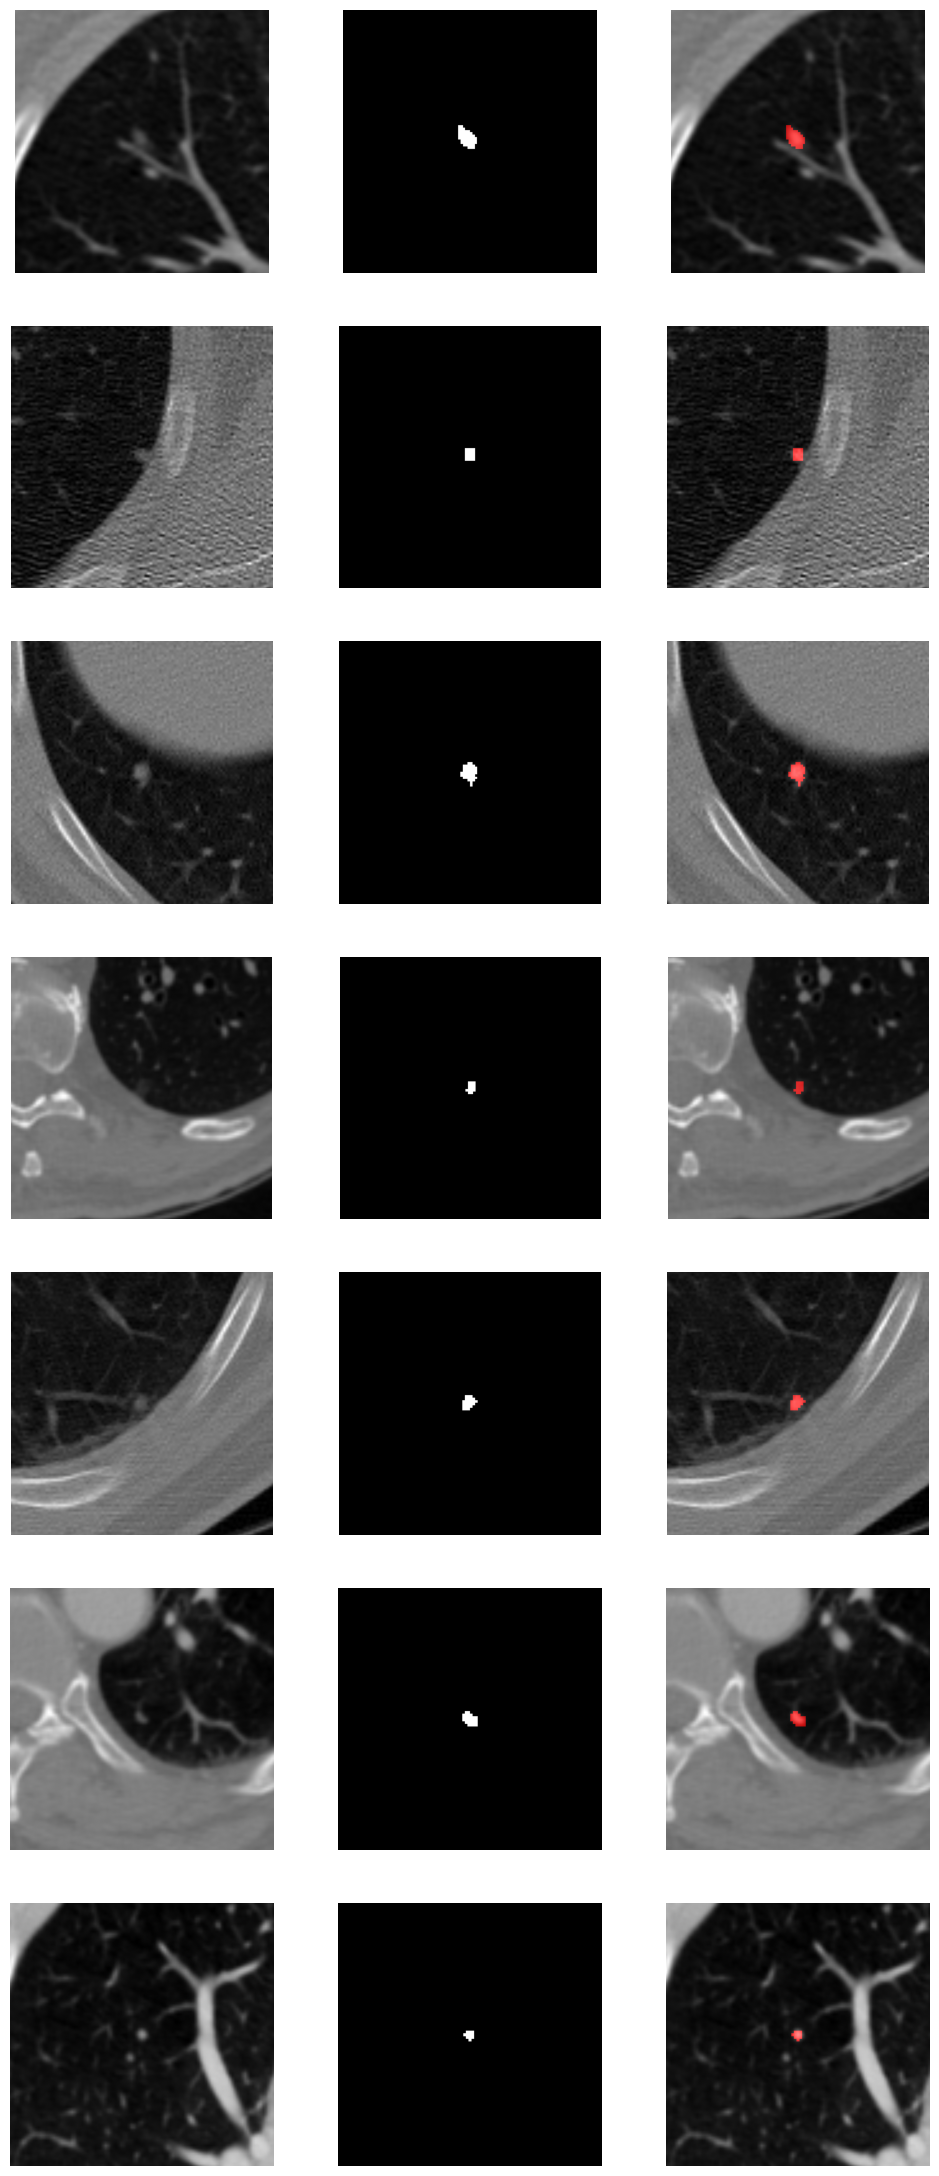

In [6]:
def plot(dataset: datasets.Dataset, qty=10):
    fig, ax = plt.subplots(qty, 3, figsize=(12, 28))

    for i, item in enumerate(dataset):
        if i >= qty:
            break

        ax[i, 0].axis("off")
        ax[i, 0].imshow(item["patch"], cmap="gray")

        ax[i, 1].axis("off")
        ax[i, 1].imshow(item["patch_mask"], cmap="gray")

        patch = np.array(item["patch"])
        patch = np.permute_dims(np.stack([patch, patch, patch]), axes=(1, 2, 0))

        mask = num_to_rgb(item["patch_mask"])
        image = image_overlay(patch, mask)

        ax[i, 2].axis("off")
        ax[i, 2].imshow(image, cmap="gray")


plot(lung_dataset["train"], qty=7)

## Data Preparation

Creation of transformations for augmentation of the data and creation of the pytorch dataloaders

In [ ]:
train_transforms = A.Compose(
    [
        A.RandomCrop(
            height=TrainingConfig.IMG_HEIGHT, width=TrainingConfig.IMG_WIDTH, p=1.0
        ),
        A.SquareSymmetry(p=1.0),
        A.RandomBrightnessContrast(p=0.3),
        A.GaussNoise(std_range=(0.1, 0.2), p=0.15),
        A.Normalize(
            mean=(0.0, 0.0, 0.0),
            std=(1.0, 1.0, 1.0),
            max_pixel_value=255.0,
            p=1.0,
        ),
        A.ToTensorV2(),
    ]
)


val_transform = A.Compose(
    [
        A.CenterCrop(
            height=TrainingConfig.IMG_HEIGHT, width=TrainingConfig.IMG_WIDTH, p=1.0
        ),
        A.Normalize(
            mean=(0.0, 0.0, 0.0),
            std=(1.0, 1.0, 1.0),
            max_pixel_value=255.0,
            p=1.0,
        ),
        A.ToTensorV2(),
    ]
)

In [8]:
def map_image_transforms(transformations):

    def wrapper(batch):
        augmented = []
        keys = batch.keys()
        for item in zip(*batch.values()):
            items = {k: np.array(v) for k, v in zip(keys, item)}
            values = transformations(**items)
            augmented.append(values)

        for key in keys:
            batch[key] = [item[key] for item in augmented]

        return batch

    return wrapper

In [9]:
new_lung_dataset = (
    lung_dataset.remove_columns(["image", "image_mask"])
    .rename_column("patch", "image")
    .rename_column("patch_mask", "mask")
)

In [ ]:
# Create a pytorch train dataset split
lung_train_dataset = new_lung_dataset["train"].with_format("torch")
lung_train_dataset.set_transform(
    map_image_transforms(train_transforms),
    columns=["image", "mask"],
)

# Create pytorch valid and test datasets split
tmp_dataset = new_lung_dataset["test"].train_test_split(
    train_size=0.5,
    seed=42,
)

lung_valid_dataset = new_lung_dataset["train"].with_format("torch")
lung_valid_dataset.set_transform(
    map_image_transforms(val_transform),
    columns=["image", "mask"],
)

lung_test_dataset = new_lung_dataset["test"].with_format("torch")
lung_test_dataset.set_transform(
    map_image_transforms(val_transform),
    columns=["image", "mask"],
)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    lung_train_dataset,
    batch_size=TrainingConfig.BATCH_SIZE,
    shuffle=False,
)

valid_dataloader = torch.utils.data.DataLoader(
    lung_valid_dataset,
    batch_size=TrainingConfig.BATCH_SIZE,
    shuffle=False,
)

test_dataset = torch.utils.data.DataLoader(
    lung_test_dataset,
    batch_size=TrainingConfig.BATCH_SIZE,
    shuffle=False,
)

## Model Selection

In [ ]:
class ConvBlock(torch.nn.Module):

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=(3, 3),
        stride=1,
        padding=0,
        dilation=1,
        bias=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.bias = bias

        self.build()

    def build():
        self.conv1 = torch.nn.Conv2d(
            self.in_channels,
            self.out_channels,
            self.kernel_size,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            bias=self.bias,
        )
        self.norm1 = torch.nn.BatchNorm2d(self.out_channels)
        self.relu1 = torch.nn.ReLU(inplace=False)

    def forward(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.norm1(x)
        x = self.relu1(x)

        return x

In [ ]:
class UNet(torch.nn.Module):

    def __init__(self):
        super().__init__()s

    